# Systrace Parser

In [1]:
import logging
from conf import LisaLogging
LisaLogging.setup()

2019-10-07 23:59:13,974 INFO    : root         : Using LISA logging configuration:
2019-10-07 23:59:13,977 INFO    : root         :   /home/ubuntu/Android/lisa_old/logging.conf


In [2]:
%pylab inline

import os
from time import sleep

# Support to access the remote target
import devlib
from env import TestEnv

# Import support for Android devices
from android import Screen, Workload

from devlib.utils.android import adb_command

# Support for trace events analysis
from trace import Trace

# Suport for FTrace events parsing and visualization
import trappy
import glob

import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame

import ipywidgets as widgets
from IPython.display import display

from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import Javascript, display

from android import System

import subprocess

from systrace_parser import systrace_parser

2019-10-07 23:59:14,214 INFO    : root         : Generating grammar tables from /usr/lib/python2.7/lib2to3/Grammar.txt
2019-10-07 23:59:14,228 INFO    : root         : Generating grammar tables from /usr/lib/python2.7/lib2to3/PatternGrammar.txt


Populating the interactive namespace from numpy and matplotlib


## Test environment setup

**devlib** requires the ANDROID_HOME environment variable configured to point to your local installation of the Android SDK. If you have not this variable configured in the shell used to start the notebook server, you need to run a cell to define where your Android SDK is installed or specify the ANDROID_HOME in your target configuration.

In case more than one Android device are conencted to the host, you must specify the ID of the device you want to target in **my_target_conf**. Run **adb devices** on your host to get the ID.

In [3]:
import os
os.environ['ANDROID_HOME'] = '/home/ubuntu/Android/AndroidSDK/'

In [4]:
conf = {
    
    # Target platform and board
    "platform"    : 'android',
    "board"       : 'pixel',

    # Device ID
    #"device"      : "HT6670300102",
    
    # Android home
    "ANDROID_HOME" : "/home/ubuntu/Android/AndroidSDK",
    
    # Lisa home
    "LISA_HOME" : "/home/ubuntu/Android/lisa_old",

    # Systrace home
    "SYSTRACE_HOME" : "/ipynb/performance/testingdata",
    
    "MAX_CORE_NUM" : 8
}

## Filters

In [6]:
trace_mark_filters = {
    'launching' : {
        'SMARK' : {'context' : 'launching:', 'type' : 'S'}, 
        'EMARK' : {'context' : 'launching:', 'type' : 'F'},
    },
    'ActivityThreadMain' : {
        'SMARK' : {'context' : 'ActivityThreadMain', 'type' : 'B'}, 
        'EMARK' : {'context' : 'ActivityThreadMain', 'type' : 'E'},
    },
    'bindApplication' : {
        'SMARK' : {'context' : 'bindApplication', 'type' : 'B'}, 
        'EMARK' : {'context' : 'bindApplication', 'type' : 'E'},
    },
    'activityStart' : {
        'SMARK' : {'context' : 'activityStart', 'type' : 'B'}, 
        'EMARK' : {'context' : 'activityStart', 'type' : 'E'},
    },
    'activityResume' : {
        'SMARK' : {'context' : 'activityResume', 'type' : 'B'}, 
        'EMARK' : {'context' : 'activityResume', 'type' : 'E'},
    },
    'Choreographer' : {
        'SMARK' : {'context' : 'Choreographer#doFrame', 'type' : 'B'}, 
        'EMARK' : {'context' : 'Choreographer#doFrame', 'type' : 'E'},
        'SEPERATE' : [0, 1],
    },
    'setSurface' : {
        'SMARK' : {'context' : 'setSurface', 'type' : 'B'}, 
        'EMARK' : {'context' : 'setSurface', 'type' : 'E'},
    },
}

In [7]:
def MismatchedStringWithoutNumber(comp1, comp2):
    comp1 = unicode(comp1)
    comp2 = unicode(comp2)
    count = 0
    for index in range(min(len(comp1), len(comp2))):
        if comp1[index] != comp2[index] and not comp1[index].isnumeric() and not comp1[index].isnumeric():
            count += 1
            
    return count
#print(MismatchedStringWithoutNumber('A207FSH9_POS_190822_190822_104817_calllog?', 'A207FSH9_POS_190822_180922_104475_calllog1'))

## Select systraces

In [8]:

count = 0
dirname = ''
dirnames = ''
chboxes = list()
chboxes_descriptions = list()

for (path, dir, files) in os.walk(conf['LISA_HOME'] + conf['SYSTRACE_HOME'] + '/'):
    if len(dir) > 0:
        dirnames = dir
    file_groups = list()
    for filename in files:
        if filename.split('.')[-1] == 'html':
            filename = filename[:-5]
            #print(filename)
            new_one = True
            for file_group in file_groups:
                #length_of_file = len(filename)
                #if length_of_file == len(file_group) and filename[:length_of_file/2] == file_group[:length_of_file/2]:
                if not MismatchedStringWithoutNumber(filename, file_group):
                    #print('before  {}'.format(file_groups))
                    #if not file_group.contains('[?]'):
                    #    file_groups.remove(file_group)
                        #file_groups.append('{}?{}'.format(file_group[:-6],file_group[-5:]))
                    #    file_groups.append('{}[?]'.format(file_group[:-3]))
                        #print('after  {}'.format(file_groups))
                    new_one = False
                    break
            if new_one:
                file_groups.append(filename)

    for file_group in file_groups:
        chboxes_descriptions.append('{}{}'.format(dirname, file_group))
    if len(dirnames) > count:
        dirname = dirnames[count] + '/'
    else:
        dirname = ''
    count += 1
    
chboxes_descriptions.sort()
#display(chboxes_descriptions)
for chboxes_description in chboxes_descriptions:
        chboxes.append(widgets.Checkbox(
                value=False,
                description=chboxes_description.decode("utf-8"),
                disabled=False,
                layout=widgets.Layout(width="200%"),
                style={'description_width': 'initial'}
        ))

toggle = widgets.ToggleButton(
    description='START'
)

#chboxes[4].value = True
#chboxes[16].value = True

display(widgets.VBox(chboxes))

VkJveChjaGlsZHJlbj0oQ2hlY2tib3godmFsdWU9RmFsc2UsIGRlc2NyaXB0aW9uPXUnQTAxNUYvQlNQLUFTVFJPJywgbGF5b3V0PUxheW91dCh3aWR0aD11JzIwMCUnKSwgc3R5bGU9RGVzY3LigKY=


## Run cells

In [11]:
def run_all(button):
    #get_ipython().run_cell()
    display(Javascript('IPython.notebook.execute_cells_below()'))

button = widgets.Button(description="Run all below")
button.on_click(run_all)
display(button)

<IPython.core.display.Javascript object>

Button(description=u'Run all below', style=ButtonStyle())

## Get file list

In [12]:
filelist = list()
title = list()

for chbox in chboxes:
    if chbox.value:
        #print(chbox.description)
        file_path = chbox.description.split('/')
        new_file_path = ''
        if len(file_path) > 1:
            for idx in range(len(file_path) - 1):
                new_file_path += file_path[idx] + '/'
        #length_of_file = len(file_path[-1])
        #new_file_path += file_path[-1][:-3] + '*.html'
        new_file_path += '*.html'
        #print(new_file_path)
        
        gathering_filelist = list()
        for dir_file in glob.glob(conf['LISA_HOME'] + conf['SYSTRACE_HOME'] + '/' + new_file_path):
            if not MismatchedStringWithoutNumber(file_path[-1], dir_file.split('/')[-1]):
                #print(dir_file)
                gathering_filelist.append(dir_file)
        filelist.append(gathering_filelist)
        #filelist[-1].sort()
        title += [file_path[-2] + "_" + file_path[-1]]

if len(filelist) == 0:
    raise  ValueError('Please select some groups of systrace in the over cell.')

## Read Files

In [13]:
group1 = systrace_parser(trace_mark_filters, filelist[0], title[0])
group2 = systrace_parser(trace_mark_filters, filelist[1], title[1])

In [14]:
group1.run()
group2.run()

Parsing G975U_P_TEST.html - 339042 lines are Ok
Parsing G975U_Q_TEST.html - 215841 lines are Ok


## Analysis

### The timing of marking data

In [15]:
list_of_df = group1.get_marking_time()
print(group1.title)
for df in list_of_df:
    display(df * 1000)

W2020_W2020 SJ5_taobao_trace


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
7905.0,0.778,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3684.0,NaN,4.892,NaN,NaN,NaN,NaN,NaN,NaN
3589.0,0.718,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1625.0,NaN,0.877,0.604,NaN,NaN,NaN,NaN,NaN
2377.0,0.233,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7882.0,NaN,12.222,NaN,NaN,NaN,NaN,NaN,NaN
1869.0,NaN,5.766,1.014,NaN,NaN,NaN,NaN,NaN
1417.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019.083
1624.0,NaN,0.647,0.327,NaN,NaN,NaN,NaN,NaN


In [16]:
list_of_df = group2.get_marking_time()
print(group2.title)
for df in list_of_df:
    display(df * 1000)

W2020_huawei_P30_Pro_taobao_trace_1st


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
1572.0,NaN,0.635,5.136,NaN,NaN,NaN,NaN,NaN
1573.0,NaN,0.458,0.449,NaN,NaN,NaN,NaN,NaN
2023.0,0.003,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2376.0,0.548,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8220.0,NaN,9.404,40.863,553.735,148.243,10.846,50.17,NaN
1256.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1365.247
8178.0,NaN,NaN,NaN,252.858,NaN,14.196,NaN,NaN
1939.0,NaN,5.689,3.664,NaN,NaN,NaN,NaN,NaN
8444.0,33.797,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Launching Time(AVERAGE)

In [17]:
list_of_df = group1.get_marking_time()
count1 = 0

for df in list_of_df:
    get_launching = df[df['launching'] > 0]

    if len(get_launching.index) :
        count1 += 1
        try :
            sum_df1 = pd.concat([sum_df1, get_launching])
        except :
            sum_df1 = get_launching

sum_df1 = DataFrame(sum_df1.sum(axis=0)).swapaxes("index", "columns") 
sum_df1.index = [group1.title]
sum_df1 = sum_df1.replace(0, NaN).dropna(axis=1)


list_of_df = group2.get_marking_time()
count2 = 0

for df in list_of_df:
    get_launching = df[df['launching'] > 0]
    
    if len(get_launching.index) :
        count2 += 1
        try :
            sum_df2 = pd.concat([sum_df2, get_launching])
        except :
            sum_df2 = get_launching
        
sum_df2 = DataFrame(sum_df2.sum()).swapaxes("index", "columns") 
sum_df2.index = [group2.title]
sum_df2 = sum_df2.replace(0, NaN).dropna(axis=1)

pd.concat([sum_df1 * 1000 / count1, sum_df2 * 1000 / count2])

,launching
W2020_W2020 SJ5_taobao_trace,2019.083
W2020_huawei_P30_Pro_taobao_trace_1st,1365.247


### Process Time(AVERAGE)

In [18]:
df1 = group1.get(systrace_parser.process_state()) * 1000
df1 = df1.fillna(0)
df1 = df1.round(3)
df1.columns.name = group1.title
#display(df1)

df2 = group2.get(systrace_parser.process_state()) * 1000
df2 = df2.fillna(0)
df2 = df2.round(3)
df2.columns.name = group2.title
#display(df2)

df_gap = df1 - df2
df_gap.columns.name = 'DIFF'
#display(df_gap)

display(pd.concat([df1, df2, df_gap], keys=[group1.title, group2.title, 'DIFF'], sort=False))
display(pd.concat([df1[:1], df2[:1], df_gap[:1]], keys=[group1.title, group2.title, 'DIFF'], sort=False))

setSurface  \
W2020_W2020 SJ5_taobao_trace          time                                0   
                                      RUNNING                             0   
                                      RUNNABLE                            0   
                                      SLEEPING                            0   
                                      UNINTERUPTIBLE_SLEEP                0   
                                      UNINTERUPTIBLE_SLEEP(I/O)           0   
W2020_huawei_P30_Pro_taobao_trace_1st time                                0   
                                      RUNNING                             0   
                                      RUNNABLE                            0   
                                      SLEEPING                            0   
                                      UNINTERUPTIBLE_SLEEP                0   
                                      UNINTERUPTIBLE_SLEEP(I/O)           0   
DIFF                                  time                                0   
                                      RUNNING                             0   
                                      RUNNABLE                            0   
                                      SLEEPING                            0   
                                      UNINTERUPTIBLE_SLEEP                0   
                                      UNINTERUPTIBLE_SLEEP(I/O)           0   

                                                                 Choreographer #0  \
W2020_W2020 SJ5_taobao_trace          time                                 13.711   
                                      RUNNING                               4.945   
                                      RUNNABLE                              4.053   
                                      SLEEPING                              3.644   
                                      UNINTERUPTIBLE_SLEEP                  1.069   
                                      UNINTERUPTIBLE_SLEEP(I/O)             0.000   
W2020_huawei_P30_Pro_taobao_trace_1st time                                  9.404   
                                      RUNNING                               2.310   
                                      RUNNABLE                              0.651   
                                      SLEEPING                              4.684   
                                      UNINTERUPTIBLE_SLEEP                  1.759   
                                      UNINTERUPTIBLE_SLEEP(I/O)             0.000   
DIFF                                  time                                  4.307   
                                      RUNNING                               2.635   
                                      RUNNABLE                              3.402   
                                      SLEEPING                             -1.040   
                                      UNINTERUPTIBLE_SLEEP                 -0.690   
                                      UNINTERUPTIBLE_SLEEP(I/O)             0.000   

                                                                 Choreographer #1  \
W2020_W2020 SJ5_taobao_trace          time                                 56.152   
                                      RUNNING                               0.944   
                                      RUNNABLE                              0.094   
                                      SLEEPING                             53.761   
                                      UNINTERUPTIBLE_SLEEP                  1.353   
                                      UNINTERUPTIBLE_SLEEP(I/O)             0.000   
W2020_huawei_P30_Pro_taobao_trace_1st time                                 40.863   
                                      RUNNING                               1.046   
                                      RUNNABLE                              0.053   
                                      SLEEPING                             38.660   
            

,,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
W2020_W2020 SJ5_taobao_trace,time,0,13.711,56.152,574.856,201.885,14.826,71.984,0
W2020_huawei_P30_Pro_taobao_trace_1st,time,0,9.404,40.863,553.735,148.243,10.846,50.170,0
DIFF,time,0,4.307,15.289,21.121,53.642,3.980,21.814,0


### Processing time of setSurface

In [19]:
def ProcessingTime(group, index):
    result = dict()
    list_of_df = group.get_marking_time()
    sum = 0
    count = 0
    for df in list_of_df:
        df = df['setSurface'].fillna(0)
        max_value = df.max() * 1000
        sum += max_value
        count += 1
        result[count] = [max_value]
    #print("SUM : {}, AVG : {}".format(sum, sum/count))
    result['avg'] = [sum/count]
    
    df = DataFrame.from_dict(result)
    df.index = [group.title]
    return df

In [20]:
df1 = ProcessingTime(group1, 'setSurface')
df2 = ProcessingTime(group2, 'setSurface')
display(pd.concat([df1, df2]))

,1,avg
W2020_W2020 SJ5_taobao_trace,54.089,54.089
W2020_huawei_P30_Pro_taobao_trace_1st,33.797,33.797


### Uninterruptible Sleep

In [21]:
index1 = group1.unint_sleep()
index2 = group2.unint_sleep()
union_index = index1
for index in index2:
    if not index in union_index:
        union_index += [index]

union_index.sort()
        
df1 = group1.get(union_index, func='avg').sort_index()
df1 = df1.dropna(axis=1)

df2 = group2.get(union_index, func='avg').sort_index()
df2 = df2.dropna(axis=1)

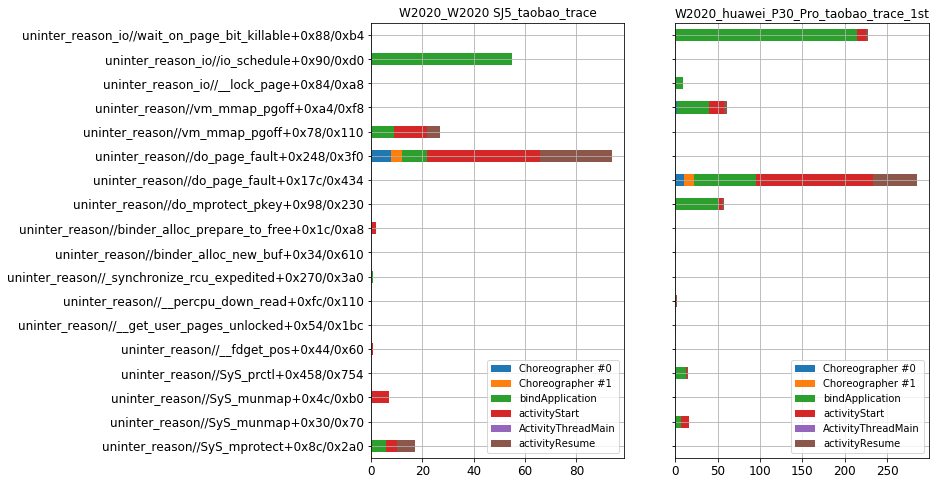

In [22]:
fig,axes = plt.subplots(nrows=1, ncols=2, sharey=True)
df1.plot(kind='barh', ax=axes[0], figsize=(10,8), grid=True, fontsize=12, stacked=True, title=group1.title)
df2.plot(kind='barh', ax=axes[1], figsize=(10,8), grid=True, fontsize=12, stacked=True, title=group2.title)

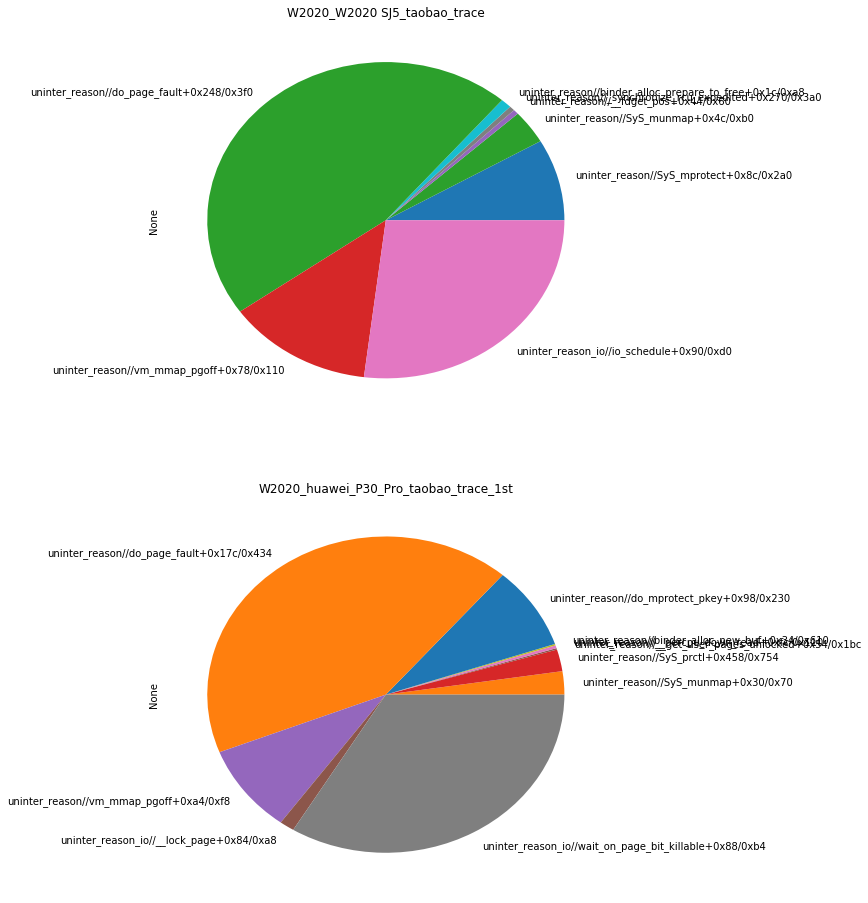

In [23]:
fig,axes = plt.subplots(nrows=2, ncols=1, sharey=True)
df1.sum(axis=1).plot(kind='pie', ax=axes[0], figsize=(8,16), title=group1.title)
df2.sum(axis=1).plot(kind='pie', ax=axes[1], figsize=(8,16), title=group2.title)

### Number of Running Cores(SUM)

Choreographer #0  \
W2020_W2020 SJ5_taobao_trace          core0                 0   
                                      core1                 0   
                                      core2                 0   
                                      core3                 0   
                                      core4                 0   
                                      core5                 0   
                                      core6                 0   
                                      core7                20   
W2020_huawei_P30_Pro_taobao_trace_1st core0                 0   
                                      core1                 0   
                                      core2                 1   
                                      core3                 0   
                                      core4                 0   
                                      core5                 5   
                                      core6                11   
                                      core7                 4   

                                             Choreographer #1  \
W2020_W2020 SJ5_taobao_trace          core0                 0   
                                      core1                 0   
                                      core2                 0   
                                      core3                 0   
                                      core4                 0   
                                      core5                 0   
                                      core6                 0   
                                      core7                 7   
W2020_huawei_P30_Pro_taobao_trace_1st core0                 0   
                                      core1                 0   
                                      core2                 0   
                                      core3                 0   
                                      core4                 4   
                                      core5                 6   
                                      core6                 2   
                                      core7                 4   

                                             bindApplication  activityStart  \
W2020_W2020 SJ5_taobao_trace          core0                0              3   
                                      core1                0              3   
                                      core2                0              1   
                                      core3                0              1   
                                      core4               17             42   
                                      core5               16             11   
                                      core6                8             35   
                                      core7              215            115   
W2020_huawei_P30_Pro_taobao_trace_1st core0                2              0   
                                      core1                1              3   
                                      core2                3              0   
                                      core3                1              0   
                                      core4               60             70   
                                      core5               41             61   
                                      core6              342            112   
                                      core7              104             61   

                                             ActivityThreadMain  \
W2020_W2020 SJ5_taobao_trace          core0                   0   
                                      core1                   1   
                                      core2                   0   
                                      core3                   0   
                                      core4                   0   
                                      core5                   0   
                    

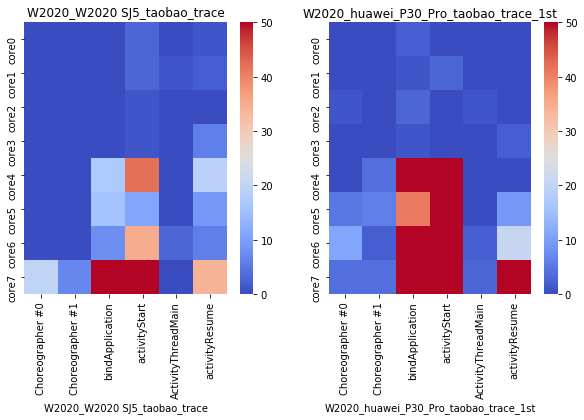

In [24]:
df1 = group1.get(group1.cores(), func='sum')
df1 = df1.dropna(axis=1)
df1.columns.name = group1.title
#display(df1)

df2 = group2.get(group2.cores(), func='sum')
df2 = df2.dropna(axis=1)
df2.columns.name = group2.title
#display(df2)
display(pd.concat([df1, df2], keys=[group1.title, group2.title], sort=False))

plt.figure(figsize=(10, 5))
#sb.palplot(sb.color_palette("hls", 8))
subplot(1,2,1, title=group1.title)
sb.heatmap(data=df1, cmap='coolwarm', center=25, vmax = 50);
subplot(1,2,2, title=group2.title)
sb.heatmap(data=df2, cmap='coolwarm', center=25, vmax = 50);

In [25]:
for parser in group1.parsers_of_testing:
    display(parser.get(group1.cores()))

,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,0,0,0,0,0,0,NaN
core1,NaN,0,0,0,0,0,0,NaN
core2,NaN,0,0,0,0,0,0,NaN
core3,NaN,0,0,0,0,0,0,NaN
core4,NaN,4,0,3,16,0,6,NaN
core5,NaN,3,0,0,9,0,6,NaN
core6,NaN,6,0,14,4,3,0,NaN
core7,NaN,5,3,0,5,0,10,NaN


In [26]:
for parser in group2.parsers_of_testing:
    display(parser.get(group2.cores()))

,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,0,0,0,0,0,0,NaN
core1,NaN,0,0,0,0,0,0,NaN
core2,NaN,0,0,0,0,0,0,NaN
core3,NaN,0,0,0,0,0,0,NaN
core4,NaN,7,0,1,20,0,11,NaN
core5,NaN,2,1,22,12,0,4,NaN
core6,NaN,1,0,9,6,4,2,NaN
core7,NaN,0,0,0,4,0,0,NaN


In [40]:
from systrace_parser import TAG_CORE_IDLE
def GetCoreStats(group):
    for parser in group.parsers_of_testing:
        rawdata = parser.get_rawdata('stat_core')
        index_key_list = list()
        df_list = list()
        
        for index_key in rawdata.keys():
            #print(index_key)
            index_key_list.append(index_key)

            core_state_dict = dict()
            for i in range(8):
                core_state_dict[i] = list()
            core_state_dict['selected'] = list()
            core_state_dict['time'] = list()

            for core_state in rawdata[index_key]:
                for i in range(8):
                    core_state_dict[i].append(core_state.get(i, TAG_CORE_IDLE))
                core_state_dict['selected'].append(core_state.get('selected', -1))
                core_state_dict['time'].append(core_state.get('time', -1))
            #display(DataFrame.from_dict(core_state_dict))
            df_list.append(DataFrame.from_dict(core_state_dict))

    return pd.concat(df_list, keys=index_key_list, sort=False).sort_values(by=['time'])
pd.set_option('display.max_rows', 500)

In [28]:
display(GetCoreStats(group1))

0  1  2  3  4  5  6  7  selected        time
ActivityThreadMain 0    R  I  R  I  I  I  V  I         6  502.755029
                   1    R  I  I  I  I  I  V  I         6  502.755821
                   2    R  V  R  I  I  I  I  I         1  502.761502
                   3    I  I  I  I  I  R  V  I         6  502.768709
bindApplication    0    R  I  I  I  R  I  R  V         7  502.769805
                   1    I  I  I  I  I  I  I  V         7  502.770359
                   2    I  R  R  I  I  I  I  V         7  502.770525
                   3    I  I  I  I  I  I  I  V         7  502.771392
                   4    I  I  I  I  I  I  I  V         7  502.771583
                   5    I  I  R  I  I  I  I  V         7  502.780067
                   6    I  R  R  R  I  I  I  V         7  502.780105
                   7    I  I  R  I  I  R  I  V         7  502.781022
                   8    R  R  I  I  I  R  I  V         7  502.781442
                   9    R  R  I  I  I  R  I  V         7  502.781838
                   10   I  I  I  I  I  R  I  V         7  502.782258
                   11   I  I  I  I  I  I  R  V         7  502.782654
                   12   I  I  I  I  I  I  R  V         7  502.783020
                   13   I  I  I  I  I  I  R  V         7  502.783474
                   14   I  I  I  I  I  I  R  V         7  502.783863
                   15   R  I  I  I  I  R  I  V         7  502.784276
                   16   R  I  I  I  I  R  I  V         7  502.784756
                   17   I  I  I  I  I  R  I  V         7  502.785186
                   18   R  I  I  I  I  R  I  V         7  502.785579
                   19   R  I  I  I  I  R  I  V         7  502.785928
                   20   I  I  I  I  I  I  R  V         7  502.789021
                   21   I  I  I  I  I  I  R  V         7  502.789360
                   22   R  R  I  R  I  I  I  V         7  502.793953
                   23   I  R  I  I  I  I  I  V         7  502.794426
                   24   I  R  I  I  I  I  I  V         7  502.795240
                   25   I  I  R  I  I  I  I  V         7  502.795691
                   26   I  R  I  I  R  I  I  V         7  502.796412
                   27   I  R  R  I  I  I  I  V         7  502.796800
                   28   I  R  R  I  I  I  I  V         7  502.797117
                   29   I  R  R  I  I  I  I  V         7  502.797460
                   30   I  R  I  R  I  I  I  V         7  502.797791
                   31   I  I  I  R  I  I  I  V         7  502.798113
                   32   I  I  I  I  R  R  I  V         7  502.798652
                   33   I  I  I  I  R  R  I  V         7  502.798979
                   34   I  I  I  I  I  I  I  V         7  502.799246
                   35   I  R  I  I  I  I  I  V         7  502.799542
                   36   I  R  I  I  I  I  I  V         7  502.799838
                   37   I  I  R  I  I  I  R  V         7  502.800166
                   38   I  R  I  I  I  I  R  V         7  502.800489
                   39   R  R  I  I  I  I  R  V         7  502.800817
                   40   I  R  I  I  I  I  I  V         7  502.801089
                   41   I  I  I  I  R  I  I  V         7  502.801710
                   42   I  I  I  I  R  I  R  V         7  502.802061
                   43   I  I  I  I  I  R  R  V         7  502.802336
                   44   I  R  I  I  I  I  I  V         7  502.802654
                   45   I  I  I  I  I  I  R  V         7  502.802981
                   46   I  I  R  I  I  I  R  V         7  502.803362
                   47   R  I  I  I  I  I  R  V         7  502.803709
                   48   I  I  I  I  I  I  I  V         7  502.804009
                   49   I  I  I  I  I  I  R  V         7  502.804343
                   50   I  I  I  I  I  R  R  V         7  502.804647
                   51   I  I  I  I  I  I  I  V         7  502.805099
                   52   I  I  I  I  I  I  I  V         7  502.805713
                   53 

In [29]:
display(GetCoreStats(group2))

0  1  2  3  4  5  6  7  selected        time
ActivityThreadMain 0    I  I  R  I  I  I  I  V         7  375.737363
                   1    I  R  I  R  R  I  I  V         7  375.737705
                   2    I  R  I  I  R  I  V  I         6  375.738328
                   3    I  I  I  I  I  I  V  I         6  375.738617
                   4    I  I  V  I  I  R  I  R         2  375.741877
                   5    I  I  R  R  I  R  V  I         6  375.746630
bindApplication    0    R  I  I  R  I  R  V  I         6  375.747150
                   1    R  I  I  I  I  I  V  I         6  375.747967
                   2    I  I  I  I  I  I  V  I         6  375.748073
                   3    I  I  R  I  I  I  V  I         6  375.748675
                   4    I  I  R  I  R  I  V  I         6  375.748880
                   5    I  I  R  I  I  I  V  I         6  375.749120
                   6    I  I  R  I  I  R  V  I         6  375.749273
                   7    I  V  I  I  I  I  I  I         1  375.750213
                   8    V  I  I  R  I  R  I  I         0  375.750273
                   9    R  I  I  R  I  V  I  I         5  375.750302
                   10   I  R  I  R  I  V  I  R         5  375.750375
                   11   I  I  I  R  I  V  I  I         5  375.750672
                   12   R  I  I  I  I  V  I  I         5  375.750737
                   13   I  I  R  I  R  V  I  I         5  375.751126
                   14   R  I  R  I  V  I  R  I         4  375.751209
                   15   R  I  I  I  I  V  R  I         5  375.752612
                   16   I  I  R  I  I  V  I  I         5  375.752672
                   17   I  I  R  I  I  V  R  I         5  375.752705
                   18   I  I  I  I  I  V  R  I         5  375.752741
                   19   I  I  I  I  I  V  R  R         5  375.752822
                   20   I  I  I  I  I  V  I  R         5  375.752852
                   21   I  I  I  I  I  V  I  I         5  375.752889
                   22   I  I  I  I  I  I  V  I         6  375.752975
                   23   I  I  I  I  I  R  V  I         6  375.753753
                   24   I  I  I  I  I  R  V  R         6  375.754250
                   25   I  I  I  I  I  R  V  I         6  375.754486
                   26   I  I  I  I  I  R  V  R         6  375.754501
                   27   I  I  I  I  I  R  V  R         6  375.754507
                   28   I  I  I  I  R  R  V  R         6  375.754523
                   29   I  I  I  I  I  R  V  R         6  375.754556
                   30   I  I  I  I  I  R  V  R         6  375.754568
                   31   I  I  I  I  R  R  V  R         6  375.754581
                   32   I  I  I  I  R  R  V  R         6  375.754592
                   33   I  I  I  I  I  R  V  R         6  375.754609
                   34   I  I  I  I  I  R  V  R         6  375.754620
                   35   I  I  I  I  I  R  V  R         6  375.754635
                   36   I  I  I  I  I  R  V  R         6  375.754645
                   37   I  I  I  I  R  R  V  R         6  375.754668
                   38   I  I  I  I  I  R  V  R         6  375.754690
                   39   I  I  I  I  R  R  V  R         6  375.754703
                   40   I  I  I  I  I  R  V  R         6  375.755278
                   41   I  I  I  I  R  R  V  R         6  375.755303
                   42   I  I  I  I  R  R  V  R         6  375.755316
                   43   I  I  I  I  R  R  V  R         6  375.755328
                   44   I  I  I  I  R  R  V  R         6  375.755355
                   45   I  I  I  I  R  R  V  R         6  375.755364
                   46   I  I  I  I  R  R  V  R         6  375.755374
                   47   I  I  I  I  I  R  V  R         6  375.755386
                   48   I  I  I  I  I  R  V  R         6  375.755396
                   49   I  I  I  I  R  R  V  R         6  375.755409
                   50   I  I  I  I  R  R  V  R         6  375.755432
                   51 

### Cpu Frequency

In [30]:
from systrace_parser import CPU_FREQUENCY_LIMITS
def DrawCorrectedData(group, tyep_filter, data_label, func):
    prevalue = dict()
    list_of_df_for_start = group.get_marking_time(dtype='start')
    list_of_df_for_end = group.get_marking_time(dtype='end')
    idx = 0

    for item in group.get(tyep_filter, func='array'):
        df = DataFrame(item, columns=['cpu_id', 'time', data_label])
        df = df.apply(pd.to_numeric)
        
        ### to darw launcging time ++
        min_freq = df[data_label].min()
        prevalue['launching'] = min_freq
        
        if len(list_of_df_for_start) > idx:
            launching_time = list_of_df_for_start[idx]['launching'].max()
            if launching_time > 0:
                df = df.append({'cpu_id' : 'launching', 
                           'time' : launching_time, 
                           data_label : ((min_freq + 1) * 2)}, ignore_index=True) 
        if len(list_of_df_for_end) > idx:
            launching_time = list_of_df_for_end[idx]['launching'].max()
            if launching_time > 0:
                df = df.append({'cpu_id' : 'launching', 
                           'time' : launching_time,
                           data_label : min_freq}, ignore_index=True)
        ### to darw launcging time --
        
        if func != 0:
            df = func(df)
            
        length = len(df.index)
            
        for i in range(length):
            #display(df.iloc[i])
            if df.iloc[i]['cpu_id'] in prevalue.keys():
                df = df.append({'cpu_id' : df.iloc[i]['cpu_id'], 
                           'time' : (df.iloc[i]['time'] - 0.000001), 
                           data_label : prevalue[df.iloc[i]['cpu_id']]}, ignore_index=True) 
                #display(df.iloc[i])
            prevalue[df.iloc[i]['cpu_id']] = df.iloc[i][data_label]
        
        idx += 1
        df.index = df['time']
        df = df.sort_index()
        df.groupby(['cpu_id'])[data_label].plot(legend=True, figsize=(15,4))
        plt.show()

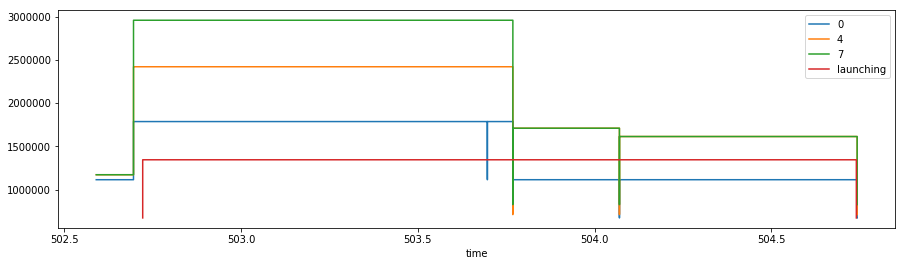

In [31]:
DrawCorrectedData(group1, CPU_FREQUENCY_LIMITS, 'min', 0)

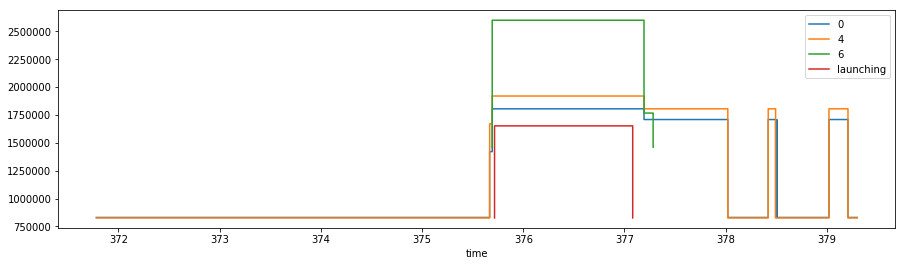

In [32]:
DrawCorrectedData(group2, CPU_FREQUENCY_LIMITS, 'min', 0)

### Cpu Idle

In [33]:
from systrace_parser import CPU_IDLE
def PreprocessingForCPUIDLE(df):
    try :
        df_launching = df[df.cpu_id == 'launching']
    except :
        df = pd.concat([df[df.cpu_id == 0], df[df.cpu_id == 4], df[df.cpu_id == 7]])

        df.loc[df.state >= 4294967295, 'state'] = -1
        df['state'] = df['state'] + 1
        
        return df

    df = pd.concat([df[df.cpu_id == 0], df[df.cpu_id == 4], df[df.cpu_id == 7]])

    df.loc[df.state >= 4294967295, 'state'] = -1
    df['state'] = df['state'] + 1
    
    df = df[df.time >= (df_launching['time'].iloc[0] - 0.1)]
    df = df[df.time <= (df_launching['time'].iloc[1] + 0.1)]
    
    df = pd.concat([df, df_launching])
    return df

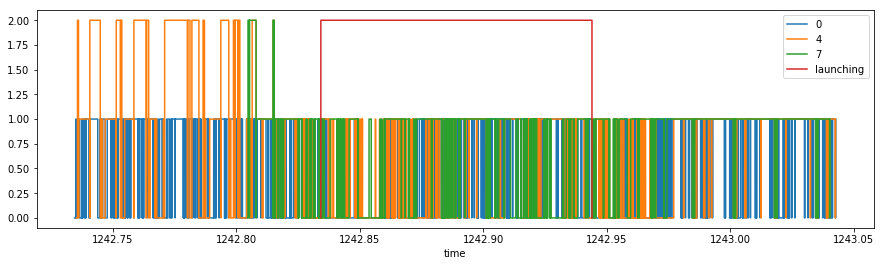

In [34]:
DrawCorrectedData(group1, CPU_IDLE, 'state', PreprocessingForCPUIDLE)

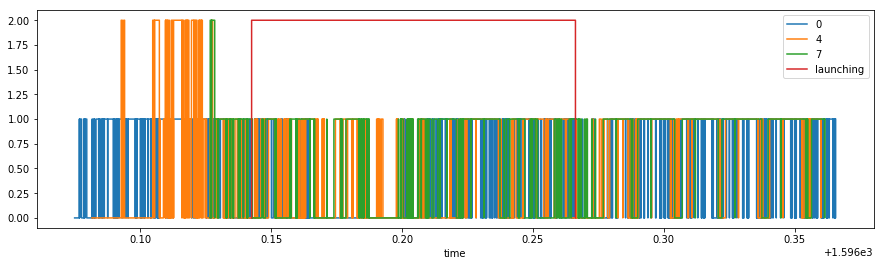

In [35]:
DrawCorrectedData(group2, CPU_IDLE, 'state', PreprocessingForCPUIDLE)

### Lock Contention

In [65]:
df1 = group1.get(['lock_contention']) * 1000
df1 = df1.fillna(0)
df1 = df1.round(3)
df1.columns.name = group1.title
#display(df1)

df2 = group2.get(['lock_contention']) * 1000
df2 = df2.fillna(0)
df2 = df2.round(3)
df2.columns.name = group2.title
#display(df2)

df_gap = df1 - df2
df_gap.columns.name = 'DIFF'
#display(df_gap)

display(pd.concat([df1, df2, df_gap], keys=[group1.title, group2.title, 'DIFF'], sort=False))
#display(pd.concat([df1[:1], df2[:1], df_gap[:1]], keys=[group1.title, group2.title, 'DIFF'], sort=False))

,,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
G975U_GLPreloading_G975U_P_TEST,lock_contention,0,5.718,4.513,0.000,17.459,0.000,0,0
G975U_GLPreloading_G975U_Q_TEST,lock_contention,0,4.515,0.000,0.453,17.626,16.297,0,0
DIFF,lock_contention,0,1.203,4.513,-0.453,-0.167,-16.297,0,0


In [66]:
def DrawLockContention(parser):
    for lock_contention in parser.storage_lock_contention:
        lock_contention['owner'] = lock_contention['context'].split('owner ')[1].split(' waiters')[0]
        lock_contention['blocking'] = lock_contention['context'].split('blocking from')[1]
    df = DataFrame.from_dict(parser.storage_lock_contention)
    df.loc[df['duration'] > 0, 'duration'] *= 1000

    return df
        #if value == 'NaN':
            
        #else:
        #    display(DataFrame(df[value].value_counts()))

Liminated the lock contentions by the main thread is sleepping in an app.
(The effection means that lock contentions seem to effect to the app entry because the process stat was sleep.)

In [67]:
#for parser in group.parsers_of_testing:
parser = group1.parsers_of_testing[0]
df = DrawLockContention(parser)
df1 = df[df['effection'] == 'O']
display(group1.title)
display(df1.sort_values(by=['duration'], ascending=False))

u'G975U_GLPreloading_G975U_P_TEST'

,blocking,context,duration,effection,owner,pid,time,type
42,java.util.List com.android.server.am.Activity...,monitor contention with owner Binder:1194_19 (...,10.272,O,Binder:1194_19 (8538) at void com.android.serv...,3120,1242.859919,B
117,void com.android.server.wm.WindowManagerServi...,monitor contention with owner Binder:1194_12 (...,5.408,O,Binder:1194_12 (3542) at int com.android.serve...,1358,1243.254638,B
25,void com.android.server.wm.WindowManagerServi...,monitor contention with owner android.anim (16...,5.008,O,android.anim (1604) at int com.android.server....,3542,1242.835718,B
32,int com.android.server.am.ActivityManagerServ...,monitor contention with owner Binder:1194_12 (...,4.648,O,Binder:1194_12 (3542) at void com.android.serv...,8538,1242.845203,B
54,void com.android.server.wm.WindowManagerServi...,monitor contention with owner Binder:1194_9 (2...,3.439,O,Binder:1194_9 (2124) at int com.android.server...,1358,1242.904929,B
26,void com.android.server.wm.WindowManagerServi...,monitor contention with owner android.anim (16...,3.368,O,android.anim (1604) at int com.android.server....,1358,1242.837430,B
44,void com.android.server.wm.WindowManagerServi...,monitor contention with owner android.anim (16...,2.703,O,android.anim (1604) at void com.android.server...,3542,1242.867249,B
115,void com.android.server.wm.WindowSurfacePlace...,monitor contention with owner Binder:1194_12 (...,2.583,O,Binder:1194_12 (3542) at int com.android.serve...,1604,1243.253070,B
116,int com.android.server.wm.WindowManagerServic...,monitor contention with owner Binder:1194_12 (...,2.468,O,Binder:1194_12 (3542) at int com.android.serve...,8538,1243.253929,B
33,int com.android.server.am.MultiWindowManagerS...,monitor contention with owner Binder:1194_12 (...,1.900,O,Binder:1194_12 (3542) at void com.android.serv...,2124,1242.847833,B


In [68]:
#for parser in group.parsers_of_testing:
parser = group2.parsers_of_testing[0]
df = DrawLockContention(parser)
df2 = df[df['effection'] == 'O']
display(group2.title)
display(df2.sort_values(by=['duration'], ascending=False))

u'G975U_GLPreloading_G975U_Q_TEST'

,blocking,context,duration,effection,owner,pid,time,type
28,int com.android.server.am.ActivityManagerServ...,monitor contention with owner Binder:992_3 (50...,8.100,O,Binder:992_3 (5057) at void com.android.server...,5452,1596.143617,B
34,void com.android.server.am.ActivityManagerSer...,monitor contention with owner Binder:992_3 (50...,7.290,O,Binder:992_3 (5057) at void com.android.server...,1143,1596.144609,B
19,void com.android.server.wm.WindowAnimator.lam...,monitor contention with owner Binder:992_A (54...,5.164,O,Binder:992_A (5452) at int com.android.server....,1147,1596.137568,B
20,void com.android.server.wm.TaskChangeNotifica...,monitor contention with owner Binder:992_A (54...,4.704,O,Binder:992_A (5452) at int com.android.server....,1143,1596.138094,B
46,boolean com.android.server.wm.WindowProcessCo...,monitor contention with owner android.anim (11...,3.882,O,android.anim (1147) at int com.android.server....,5452,1596.155550,B
51,void com.android.server.wm.WindowManagerServi...,monitor contention with owner Binder:992_3 (50...,3.349,O,Binder:992_3 (5057) at void com.android.server...,1147,1596.166558,B
152,void com.android.server.wm.WindowManagerServi...,monitor contention with owner Binder:992_12 (7...,3.308,O,Binder:992_12 (7471) at int com.android.server...,1143,1596.557373,B
118,void com.android.server.wm.WindowManagerServi...,monitor contention with owner Binder:992_A (54...,3.302,O,Binder:992_A (5452) at int com.android.server....,1143,1596.241167,B
47,void com.android.server.wm.WindowManagerServi...,monitor contention with owner android.anim (11...,3.158,O,android.anim (1147) at int com.android.server....,1143,1596.156337,B
52,android.app.ActivityManager$StackInfo com.and...,monitor contention with owner Binder:992_3 (50...,3.137,O,Binder:992_3 (5057) at void com.android.server...,1143,1596.166887,B


Sum of the lock contention's duration. The durations could be duplicated.

In [69]:
display(group1.title)
display(df1['duration'].sum())

u'G975U_GLPreloading_G975U_P_TEST'

51.4119999995728

In [70]:
display(group2.title)
display(df2['duration'].sum())

u'G975U_GLPreloading_G975U_Q_TEST'

87.24799999959032

In [71]:
parser = group1.parsers_of_testing[0]
df = DrawLockContention(parser)
df = df[df['effection'] == 'O']
display(group1.title)
display(DataFrame(df['owner'].value_counts()))

u'G975U_GLPreloading_G975U_P_TEST'

,owner
android.anim (1604) at void com.android.server.wm.WindowAnimator.animate(long)(WindowAnimator.java:153),4
"Binder:1194_12 (3542) at int com.android.server.wm.WindowManagerService.relayoutWindow(com.android.server.wm.Session, android.view.IWindow, int, android.view.WindowManager$LayoutParams, int, int, int, int, long, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.view.DisplayCutout$ParcelableWrapper, android.util.MergedConfiguration, android.view.Surface, android.graphics.PointF, com.samsung.android.view.ConventionalModeBar$Info)(WindowManagerService.java:2217)",3
"Binder:1194_19 (8538) at void com.android.server.am.ActivityManagerService.setTaskDescription(android.os.IBinder, android.app.ActivityManager$TaskDescription)(ActivityManagerService.java:13842)",2
"Binder:1194_9 (2124) at java.util.List com.android.server.am.ActivityManagerService.getFilteredTasks(int, int, int)(ActivityManagerService.java:13683)",2
"android.anim (1604) at int com.android.server.wm.WindowManagerService.relayoutWindow(com.android.server.wm.Session, android.view.IWindow, int, android.view.WindowManager$LayoutParams, int, int, int, int, long, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.view.DisplayCutout$ParcelableWrapper, android.util.MergedConfiguration, android.view.Surface, android.graphics.PointF, com.samsung.android.view.ConventionalModeBar$Info)(WindowManagerService.java:2217)",2
Binder:1194_19 (8538) at android.app.ActivityManager$StackInfo com.android.server.am.ActivityManagerService.getFocusedStackInfo()(ActivityManagerService.java:26903),2
Binder:1194_12 (3542) at void com.android.server.am.ActivityManagerService.activityPaused(android.os.IBinder)(ActivityManagerService.java:10410),2
"Binder:1194_9 (2124) at boolean android.os.MessageQueue.enqueueMessage(android.os.Message, long)(MessageQueue.java:544)",1
"Binder:1194_F (3120) at void com.android.server.InputMethodManagerService.onSessionCreated(com.android.internal.view.IInputMethod, com.android.internal.view.IInputMethodSession, android.view.InputChannel)(InputMethodManagerService.java:3119)",1
"ActivityManager (1308) at void com.android.server.am.TaskChangeNotificationController.forAllRemoteListeners(com.android.server.am.TaskChangeNotificationController$TaskStackConsumer, android.os.Message)(TaskChangeNotificationController.java:246)",1


In [72]:
parser = group2.parsers_of_testing[0]
df = DrawLockContention(parser)
df = df[df['effection'] == 'O']
display(group2.title)
display(DataFrame(df['owner'].value_counts()))

u'G975U_GLPreloading_G975U_Q_TEST'

,owner
android.anim (1147) at void com.android.server.wm.WindowAnimator.animate(long)(WindowAnimator.java:141),8
android.display (1143) at int com.android.server.wm.MultiTaskingManager.getMultiWindowModeStates(int)(MultiTaskingManager.java:568),4
"android.ui (1130) at java.util.List com.android.server.wm.ActivityTaskManagerService.getFilteredTasks(int, int, int)(ActivityTaskManagerService.java:3231)",4
android.anim (1147) at void com.android.server.wm.WindowAnimator.animate(long)(WindowAnimator.java:132),4
android.anim (1147) at void com.android.server.wm.WindowSurfacePlacer.lambda$new$0$WindowSurfacePlacer()(WindowSurfacePlacer.java:65),3
"Binder:992_12 (7471) at int com.android.server.wm.WindowManagerService.relayoutWindow(com.android.server.wm.Session, android.view.IWindow, int, android.view.WindowManager$LayoutParams, int, int, int, int, long, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.view.DisplayCutout$ParcelableWrapper, android.util.MergedConfiguration, android.view.SurfaceControl, android.view.InsetsState)(WindowManagerService.java:2194)",3
"Binder:992_3 (5057) at void com.android.server.am.ActivityManagerService.attachApplication(android.app.IApplicationThread, long)(ActivityManagerService.java:5941)",3
android.display (1143) at void com.android.server.wm.WindowManagerService$H.handleMessage(android.os.Message)(WindowManagerService.java:5248),2
"android.display (1143) at java.util.List com.android.server.pm.PackageManagerService.queryIntentActivitiesInternal(android.content.Intent, java.lang.String, int, int, int, boolean, boolean)(PackageManagerService.java:8542)",2
"android.display (1143) at void com.android.server.wm.ActivityMetricsLogger.checkVisibility(com.android.server.wm.TaskRecord, com.android.server.wm.ActivityRecord)(ActivityMetricsLogger.java:575)",2
